In [1]:
import numpy as np
import numpy.random as rand
import networkx as nx
import time
import matplotlib.pyplot as plt
from pulp import LpVariable, lpSum, LpProblem, LpMaximize, LpMinimize, value
from queue import PriorityQueue

# Shortest Path

## Graph

In [2]:
class Graph:
    def __init__(self, n):
        self.v = n
        self.max = 0
        self.edges = [[-1 for i in range(n)] for j in range(n)]
        self.Edges = []
        self.visited = []
        self.S = [[] for v in range(n)]
        self.P = [[] for v in range(n)]
        
    def addEdge(self, u, v, weight, undirected = False):
        self.max = max(self.max, weight)
        self.edges[u][v] = weight
        self.Edges += [(u,v)]
        self.S[u] += [v]
        self.P[v] += [u]
        
        if undirected:
            self.edges[v][u] = weight
            self.Edges += [(v,u)]
            self.S[v] += [u]
            self.P[u] += [v]
            
    def render(self):
        pass

In [3]:
def backTO(P, source, target):
    string = str(target)
    
    while target != source:
        string = str(P[target]) + " -> " + string
        target = P[target]
        
    return string

## Dijkstra's algorithm

In [4]:
%%time
def dijkstra(graph, source):
    D = {v:float('inf') for v in range(graph.v)}
    D[source] = 0
    P = {v:"UNDEFINED"  for v in range(graph.v)}
    pq = PriorityQueue()
    pq.put((0, source))

    while not pq.empty():
        (dist, currentVertex) = pq.get()
        graph.visited.append(currentVertex)
        for neighbor in graph.S[currentVertex]:
            distance = graph.edges[currentVertex][neighbor]
            if neighbor not in graph.visited:
                old = D[neighbor]
                new = D[currentVertex] + distance
                if new < old:
                    pq.put((new, neighbor))
                    D[neighbor] = new
                    P[neighbor] = currentVertex
    return D, P

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 8.11 µs


In [5]:
graph = Graph(6)
graph.addEdge(0,1,2)
graph.addEdge(0,2,4)
graph.addEdge(1,3,3)
graph.addEdge(2,4,2)
graph.addEdge(2,5,1)
graph.addEdge(3,4,0)
graph.addEdge(4,1,8)
graph.addEdge(4,5,5)
graph.addEdge(5,3,3)

In [6]:
D, P = dijkstra(graph, 0)

In [7]:
backTO(P, 0, 5)

'0 -> 2 -> 5'

## A* search

In [8]:
def h(x, graph):
    
    if x in graph.visited:
        return 0
    
    return (graph.v - len(graph.visited)+1)*graph.max

In [9]:
%%time
def astar(graph, source, target, h):
    pqvef = []
    pqvne  = PriorityQueue()
    pqvnef = [source]
    pqvne.put((h(source, graph), source))
    P = {v:"UNDEFINED"  for v in range(graph.v)}
    D = {v:float('inf') for v in range(graph.v)}
    D[source] = 0
    
    while not pqvne.empty():
        (dist, currentVertex) = pqvne.get()
        if currentVertex != target:
            for neighbor in graph.S[currentVertex]:
                distance = D[currentVertex] + graph.edges[currentVertex][neighbor]
                if neighbor in pqvnef:
                    if D[neighbor] < distance:
                        break
                elif neighbor in pqvef:
                    if D[neighbor] < distance:
                        break
                    pqvnef += [neighbor]
                    pqvef.remove(neighbor)
                else:
                    pqvnef += [neighbor]
                    pqvne.put((h(neighbor, graph), neighbor))
                D[neighbor] = distance
                P[neighbor] = currentVertex
            pqvef += [currentVertex]
        else:
            break
    return D, P

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


In [10]:
graph = Graph(6)
graph.addEdge(0,1,2)
graph.addEdge(0,2,4)
graph.addEdge(1,3,3)
graph.addEdge(2,4,2)
graph.addEdge(2,5,1)
graph.addEdge(3,4,0)
graph.addEdge(4,1,8)
graph.addEdge(4,5,5)
graph.addEdge(5,3,3)

In [11]:
D, P = astar(graph, 0, 5, h)

In [12]:
backTO(P, 0, 5)

'0 -> 2 -> 5'

## Bellman–Ford

In [13]:
%%time
def bellmanFord(graph, source):
    D = {v:float('inf') for v in range(graph.v)}
    D[source] = 0
    P = {v:"UNDEFINED"  for v in range(graph.v)}
    
    for v in range(graph.v - 1):
        for currentVertex, neighbor in graph.Edges:
            if D[currentVertex] + graph.edges[currentVertex][neighbor] < D[neighbor]:
                D[neighbor] = D[currentVertex] + graph.edges[currentVertex][neighbor]
                P[neighbor] = currentVertex
    # we can add another steps, step 3 and step 4, as in Wikipedia to have more versatile algorithm. 
    return D, P

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [14]:
graph = Graph(6)
graph.addEdge(0,1,2)
graph.addEdge(0,2,4)
graph.addEdge(1,3,3)
graph.addEdge(2,4,2)
graph.addEdge(2,5,1)
graph.addEdge(3,4,0)
graph.addEdge(4,1,8)
graph.addEdge(4,5,5)
graph.addEdge(5,3,3)

In [15]:
D, P = astar(graph, 0, 5, h)

In [16]:
backTO(P, 0, 5)

'0 -> 2 -> 5'

# Minimum spanning tree

## Prim

In [24]:
def prim(graph, f = lambda x,y: graph.edges[x][y]):
    u, k = rand.randint(0, graph.v), 1
    P = {v:False for v in range(graph.v)}
    D = {v:"UNDEFINED" for v in range(graph.v)}
    P[u] = True
    while k < graph.v:
        minimum = np.inf
        a, b = 0, 0
        for v in range(graph.v):
            if P[v]:
                for n in graph.S[v]:
                    if not P[n]:
                        if minimum > graph.edges[v][n]:
                            minimum = graph.edges[v][n]
                            a, b = v, n
        P[b] = True
        D[b] = a
        k   += 1
    return D

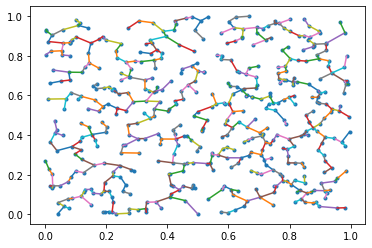

In [29]:
n = 500
u = rand.rand(n,2)
graph = Graph(n)

for i in range(n-1):
    for j in range(i+1, n): 
        graph.addEdge(i, j, np.linalg.norm(u[i]-u[j]), True)

P = prim(graph)

plt.plot(u[:,0], u[:,1], ".")
for v in range(graph.v):
    if P[v]!="UNDEFINED":
        plt.plot([u[v, 0], u[P[v], 0]], [u[v, 1], u[P[v], 1]], '-')

# Column Generation